# Model Assessment

After aggregating the data and performing feature engineering I created a LightGBM regression model to predict the hourly need for Citbikes. Then, I calculated a share percentage for each station at each hour of the week. This granularity allows both the hourly trend of the bike usage while also providing a reasonable distribution of hourly need to each station respectively

In [1]:
# Needed imports 
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
# Add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)
from scripts.train_model import train_pipeline

In [2]:
#train model- calculate shares
model, X_train, X_test, y_train, y_test, train_metrics, df_totals,station_preds = train_pipeline()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83255, number of used features: 20
[LightGBM] [Info] Start training from score 2489.904558
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 597.236	valid_0's l2: 356691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1374
[LightGBM] [Info] Number of data points in the train set: 100709, number of used features: 20
[LightGBM] [Info] Start training from score 2448.652534
[LightGBM] [Info] Au

## 1. Model Metrics

The model has strong metrics. The r^2 value being 0.9496 suggests strong statistical significance. The 

In [11]:
print("------ Model Train Metrics ------")
for k, v in train_metrics.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")
print("---------------------------------")

------ Model Train Metrics ------
test_mae: 338.9124
test_rmse: 597.2361
test_r2: 0.9496
baseline_mae: 2015.6737
baseline_rmse: 2660.2589
baseline_r2: -0.0000
cv_mae_mean: 654.7445
cv_mae_std: 180.4851
fullset_mae: 327.4912
fullset_rmse: 564.2277
fullset_bias: -1.1470
---------------------------------


## 2. Actual vs. Predicted

The following graph reveals that the created model has detected the trend of bike usage- especially yearly growth and expected dips in colder months (Dec-Mar). Also the model seems to be slightly undercounting when compared to the observed data.

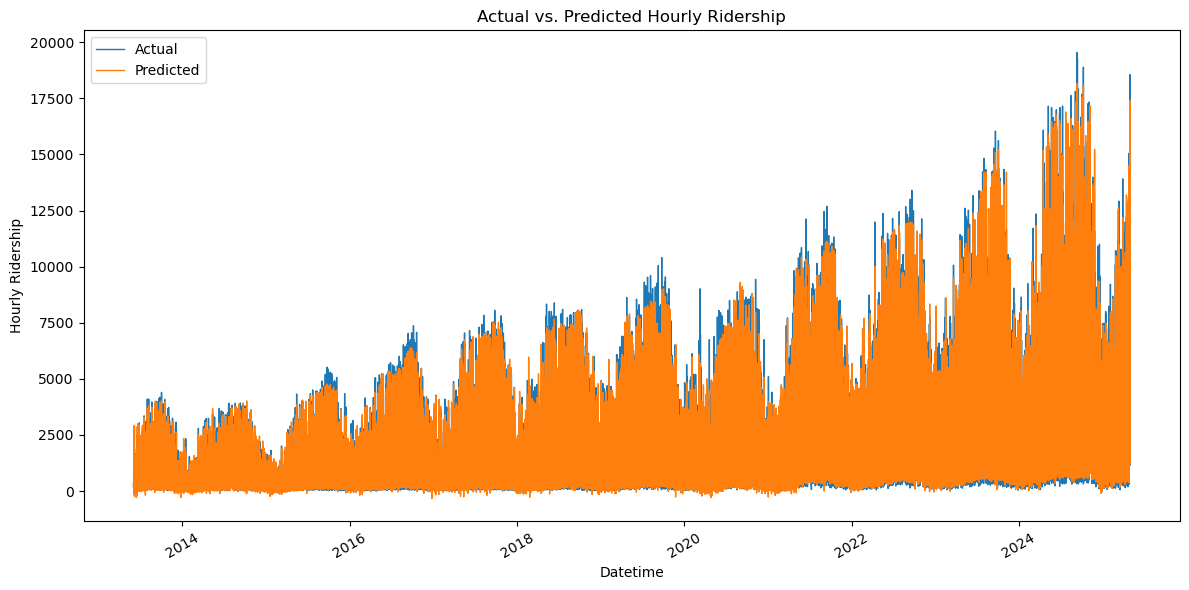

In [3]:

test_feats = df_totals.loc[X_test.index, ['datetime']].reset_index(drop=True)

#Predict on X_test
y_pred = model.predict(X_test)

plot_df = test_feats.copy()
plot_df['actual']    = y_test.values
plot_df['predicted'] = y_pred

plot_df = plot_df.sort_values('datetime')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(plot_df['datetime'], plot_df['actual'],    label='Actual',    linewidth=1)
plt.plot(plot_df['datetime'], plot_df['predicted'], label='Predicted', linewidth=1)
plt.xlabel('Datetime')
plt.ylabel('Hourly Ridership')
plt.title('Actual vs. Predicted Hourly Ridership')
plt.legend()
plt.xticks(rotation=30)   
plt.tight_layout()
plt.show()

## 3. Station Share Graphing

The following graph shows two graphs that have seemingly parallel week-day usage. This reveals that our station share prediction observes the day-to-day activity rather than a overall share. Thus, providing a more nuanced hourly prediction.

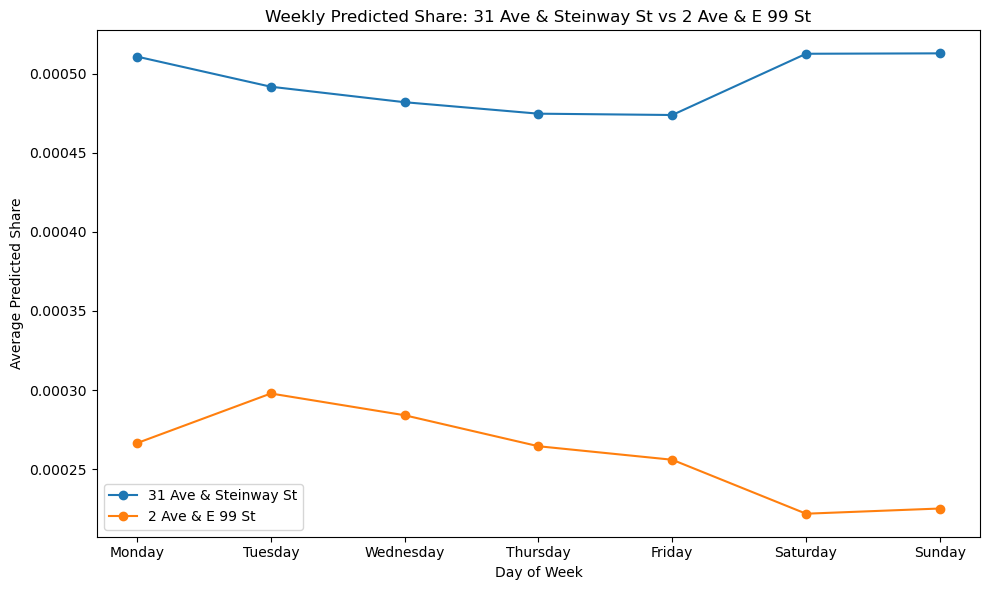

In [9]:
# Station Share by time
station_preds['total_pred'] = station_preds.groupby('datetime')['station_pred'].transform('sum')
station_preds['pred_share'] = station_preds['station_pred'] / station_preds['total_pred']

# Pick two random stations
stations = station_preds['station_name'].unique().tolist()
station_a, station_b = random.sample(stations, 2)

# daily‐average share table for two stations
df_plot = (
    station_preds[station_preds['station_name'].isin([station_a, station_b])]
    .assign(dow = lambda d: d['datetime'].dt.day_name())
    .groupby(['station_name','dow'])['pred_share']
    .mean()
    .reset_index()
)

weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df_plot['dow'] = pd.Categorical(df_plot['dow'], categories=weekday_order, ordered=True)
df_plot = df_plot.sort_values('dow')

# Plot
plt.figure(figsize=(10,6))
for name in [station_a, station_b]:
    sub = df_plot[df_plot['station_name']==name]
    plt.plot(sub['dow'], sub['pred_share'], marker='o', label=name)

plt.title(f"Weekly Predicted Share: {station_a} vs {station_b}")
plt.xlabel("Day of Week")
plt.ylabel("Average Predicted Share")
plt.legend()
plt.tight_layout()
plt.show()


## 4. Baseline vs. Model Performance

The following graph reveals that the baseline performs drastically worse than the model.

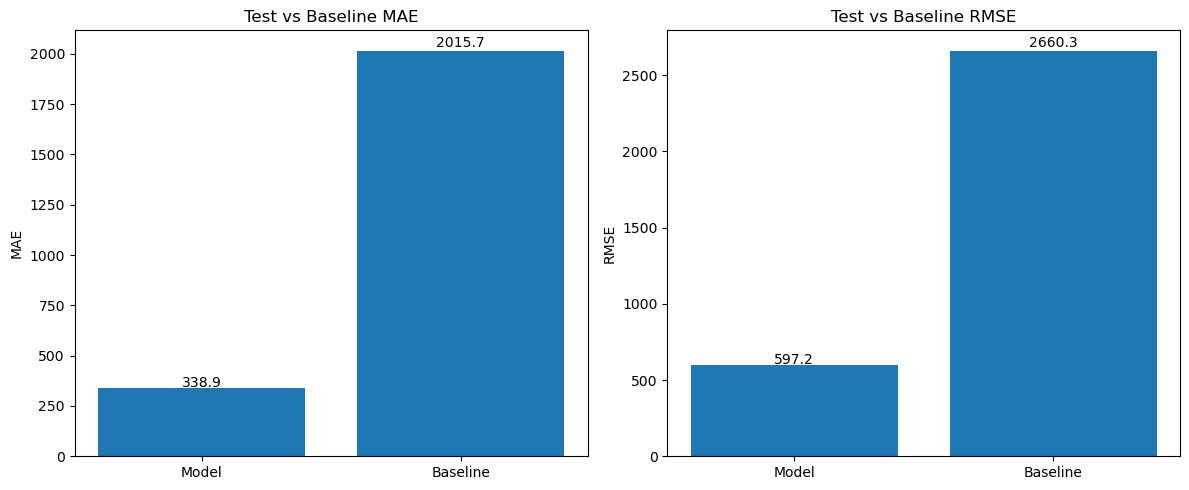

In [12]:
metrics_to_plot = {
    'MAE': ['test_mae', 'baseline_mae'],
    'RMSE': ['test_rmse', 'baseline_rmse']
}

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (label, keys) in zip(axes, metrics_to_plot.items()):
    values = [train_metrics[keys[0]], train_metrics[keys[1]]]
    ax.bar(['Model', 'Baseline'], values)
    ax.set_title(f'Test vs Baseline {label}')
    ax.set_ylabel(label)
    for i, v in enumerate(values):
        ax.text(i, v * 1.01, f'{v:.1f}', ha='center')  # annotate values

plt.tight_layout()
plt.show()

## 5. Residuals

The model's residuals have an almost normal distribution- meaning most predicted values are around 0. The residuals occur in a random rate upon looking at the mean residual by weekday & hour graph, though it does appear that on weekends the model is both under predicting and over predicting the most.

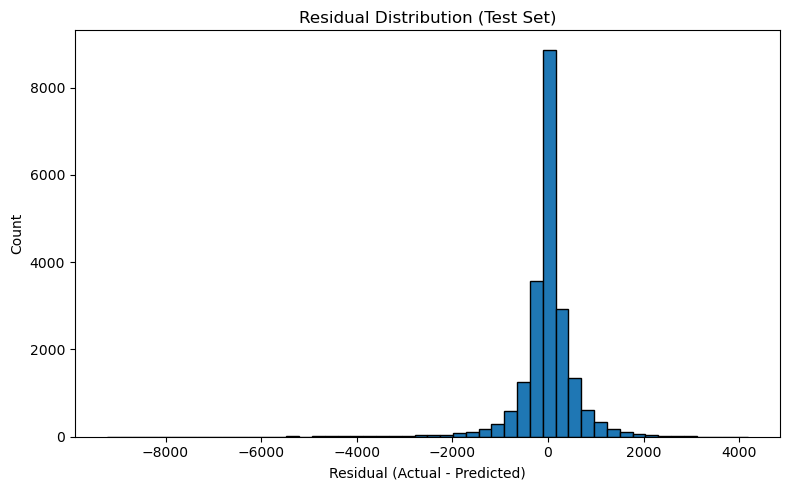

In [13]:
# compute predictions on the test set
y_pred = model.predict(X_test)

# calculate residuals (Actual - Predicted)
residuals = y_test.values - y_pred

# Plot residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=50, edgecolor='black')
plt.title('Residual Distribution (Test Set)')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

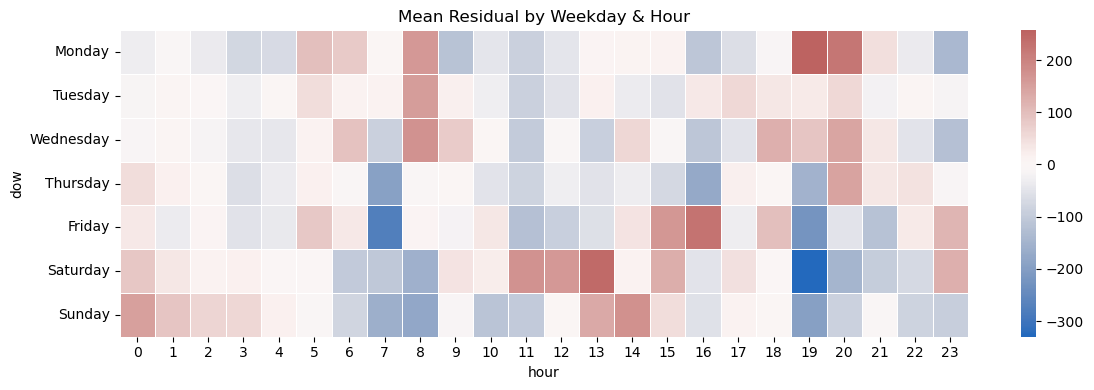

In [14]:
# build a residuals DataFrame
res = pd.DataFrame({
    'datetime': df_totals.loc[X_test.index, 'datetime'],
    'residual': y_test.values - model.predict(X_test)
})
res['hour'] = res['datetime'].dt.hour
res['dow']  = res['datetime'].dt.day_name()

pivot = res.pivot_table(
    index='dow', columns='hour', values='residual', aggfunc='mean'
).reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

#plot
plt.figure(figsize=(12,4))
sns.heatmap(pivot, center=0, cmap='vlag', linewidths=0.5)
plt.title("Mean Residual by Weekday & Hour")
plt.tight_layout()
plt.show()